In [1]:
%load_ext autoreload
%autoreload 2
import os, sys, math
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import *
from utils import *
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [2]:
# Download the players' face images:
# download_images()
# remove_error_images()

In [3]:
# Change to True when done training:
skip_training = False

In [4]:
# Specify a device for training the model:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [26]:
# Define DAVE class:
class DVAE(nn.Module):
    """ Disintangled Variational Autoencoder. """
    def __init__(self, n_latents):
        """ Initialize model. 
            
            Parameters:
                n_latents: number of latent variables
        """
        super(DVAE, self).__init__()
        self.n_latents = n_latents
        self.register_buffer('min_logvar', -6 * torch.ones(1))
        
        # Encoder network:
        self.en_conv = nn.ModuleList([nn.Conv2d(2**i, 2**(i+1), 3, 1, 1) for i in range(5, 8)])
        self.en_conv.insert(0, nn.Conv2d(3, 32, 3, 1, 1))
        self.en_norm = nn.ModuleList([nn.BatchNorm2d(2**i) for i in range(5, 9)])
        self.squeeze_conv = nn.Conv2d(256, 256, 7)
        self.z_mu = nn.Linear(256, n_latents)
        self.z_logvar = nn.Linear(256, n_latents)
        
        # Decoder network:
        self.fc = nn.Linear(n_latents, 256)
        self.de_conv = nn.ModuleList([nn.ConvTranspose2d(2**i, 2**(i-1), 3, 1, 1) for i in range(8, 5, -1)])
        self.de_conv.insert(0, nn.ConvTranspose2d(256, 256, 7))
        self.de_norm = nn.ModuleList([nn.BatchNorm2d(2**i) for i in range(8, 4, -1)])
        self.y_mu = nn.ConvTranspose2d(32, 3, 3, 1, 1)
        self.y_logvar = nn.ConvTranspose2d(32, 3, 3, 1, 1)

    def encode(self, x):
        """ Encode data to latent space. 
        
            Parameters:
                x: input tensors of shape [batch, channels, height, width]
            
            Return:
                z_mu: mean of latent variables of shape [batch, n_latents]
                z_logvar: log variance of latent variables of shape [batch, n_latents]
                indices: list of indices returned by maxpool layers
        """
        for i in range(len(self.en_conv)):
            x = self.en_conv[i](x)
            x = self.en_norm[i](x)
            x = F.max_pool2d(x, 2, 2)
            x = F.relu(x)
        x = F.relu(self.squeeze_conv(x).reshape(x.shape[0], -1))
        return self.z_mu(x), self.z_logvar(x)

    def sample(self, z_mu, z_logvar):
        """ Sample one sample from posterior of latent variable with reparametrization trick. 
        
            Parameters:
                z_mu: mean of latent variables of shape [batch, n_latents]
                z_logvar: log variance of latent variables of shape [batch, n_latents]
            
            Return:
                z: sampled latent variable of shape [batch, n_latents]
        """
        return z_mu + z_logvar.div(2).exp() * torch.randn_like(z_logvar)

    def decode(self, z):
        """ Reconstruct original data from latent representation:
        
            Parameters:
                z: sampled latent variable of shape [batch, n_latents]
                indices: list of indices returned by maxpool layers
            
            Return:
                y_mu: mean of reconstructed samples of shape [batch, channels, height, width]
                y_logvar: log variance of reconstructed samples of shape [batch, channels, height, width]
        """
        z = self.fc(z)[:, :, None, None]
        z = self.de_conv[0](z)
        z = self.de_norm[0](z)
        z = F.relu(z)
        z = F.interpolate(z, size=([15, 15]), mode='nearest')
        for i in range(1, len(self.de_conv)):
            z = self.de_conv[i](z)
            z = self.de_norm[i](z)
            z = F.relu(z)
            z = F.interpolate(z, scale_factor=2)
        m = self.y_mu(z)
        lv = self.min_logvar + F.softplus(self.y_logvar(z) - self.min_logvar)
        return F.sigmoid(m), F.sigmoid(lv)

    def forward(self, x):
        """ Forward pass. 
        
            Parameters:
                x: input tensors of shape [batch, channels, height, width]
            
            Return:
                z_mu: mean of latent variables of shape [batch, n_latents]
                z_logvar: log variance of latent variables of shape [batch, n_latents]
                y_mu: mean of reconstructed samples of shape [batch, channels, height, width]
                y_logvar: log variance of reconstructed samples of shape [batch, channels, height, width]
        """
        z_mu, z_logvar = self.encode(x)
        z = self.sample(z_mu, z_logvar)
        y_mu, y_logvar = self.decode(z)
        return z_mu, z_logvar, y_mu, y_logvar

In [20]:
def dvae_loss(x, z_mu, z_logvar, y_mu, y_logvar, beta):
    """ Variational autoencoder loss. 
        
        Parameters:
            x: input tensors of shape [batch, channels, height, width]
            z_mu: mean of latent variables of shape [batch, n_latents]
            z_logvar: log variance of latent variables of shape [batch, n_latents]
            y_mu: mean of reconstructed samples of shape [batch, channels, height, width]
            y_logvar: log variance of reconstructed samples of shape [batch, channels, height, width]   
            beta: disintangled coefficient
            
        Return:
            loss 
    """
    # Negative expected log likelihood over latent distribution:
    NLL = 0.5*((x - y_mu).pow(2).div(y_logvar.exp()) + y_logvar).sum().div(x.shape[0])
    # KL-divergence between trained latent space and standard normal distribution:
    DKL = 0.5*(z_logvar.exp() + z_mu.pow(2) - z_logvar - 1).sum().div(x.shape[0])
    return beta * DKL + NLL

In [27]:
# Define hyper-parameters for training the models
n_latents = 10
lr = 1e-3
epochs = 3
batch_size = 64
print_every = 100

# Prepare dataset and data loader:
images = FaceDataset('images', transform=ToTensor())
train_loader = DataLoader(images, batch_size=batch_size, shuffle=True, num_workers=4)

# Number of iterations in 1 epoch:
total_steps = math.ceil(len(train_loader.dataset) / batch_size)

# Initialize an instance of model:
dvae = DVAE(n_latents)
dvae.to(device)
# Choose an optimizer:
optimizer = optim.Adam(dvae.parameters(), lr=lr)

# Training loop:
for epoch in range(epochs):
    for i, x in enumerate(train_loader):
        # Remove previous gradients:
        optimizer.zero_grad()
        # Push data to device:
        x = x.to(device)
        # Feed data to model:
        z_mu, z_logvar, y_mu, y_logvar = dvae(x)
        # Compute the loss:
        loss = dvae_loss(x, z_mu, z_logvar, y_mu, y_logvar, 1)
        # Back-propagation:
        loss.backward()
        # Update parameters:
        optimizer.step()
        
        # Print out training progress (on same line):
        stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f' \
                % (epoch+1, epochs, i, total_steps, loss.item())
        print('\r' + stats, end="")
        sys.stdout.flush()
        
        # Print out training progress (on different line):
        if (i % print_every == 0):
            print('\r' + stats)

/home/vinhnguyen/.local/lib/python3.8/site-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch [1/3], Step [0/253], Loss: 12269.6982
Epoch [1/3], Step [100/253], Loss: 635.3978
Epoch [1/3], Step [200/253], Loss: 532.8219
Epoch [2/3], Step [0/253], Loss: 504.484718
Epoch [2/3], Step [100/253], Loss: 476.2596
Epoch [2/3], Step [200/253], Loss: 462.5208
Epoch [3/3], Step [0/253], Loss: 433.858941
Epoch [3/3], Step [100/253], Loss: 427.1819
Epoch [3/3], Step [200/253], Loss: 441.1741
Epoch [3/3], Step [252/253], Loss: 427.8553

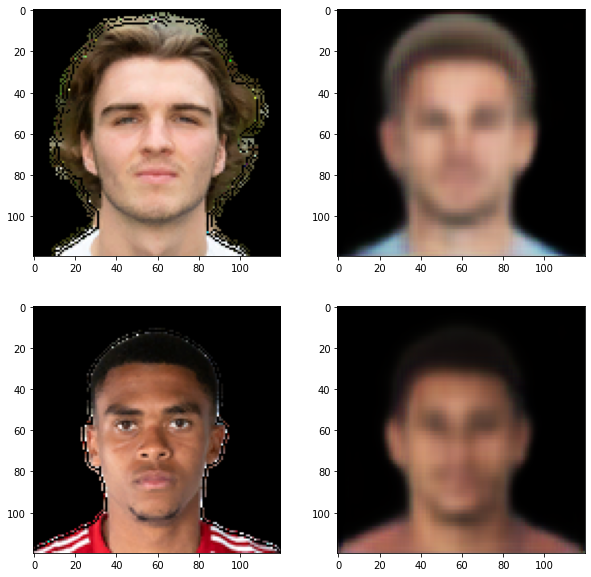

In [30]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
# Choose a sample for comparison:
num = 12783
x = torch.stack([images[num], images[num+1]]).to(device)
#x = images[num].unsqueeze(0).to(device)
# Show the original sample:
ax[0,0].imshow(images[num].detach().numpy().transpose(1, 2, 0))
ax[1,0].imshow(images[num+1].detach().numpy().transpose(1, 2, 0))
# Encode & decode the sample:
z_mu, z_logvar, y_mu, y_logvar = dvae(x)
# Show the decoded sample:
ax[0,1].imshow(y_mu[0].cpu().detach().numpy().transpose(1, 2, 0))
ax[1,1].imshow(y_mu[1].cpu().detach().numpy().transpose(1, 2, 0))

In [28]:
# Choose a sample for comparison:
num = 12783
x = torch.stack([images[num], images[num+1]]).to(device)
# Encoder & decode samples:
z_mu, z_logvar, y_mu, y_logvar = dvae(x)
# Find and decoder latent representations between 2 samples:
z1, z2 = z_mu[0], z_mu[1]
step = 10
dist = torch.dist(z1, z2).item()
direct = (z2 - z1) / step
inter = torch.stack([z1 + direct*i for i in range(step)])
y_mu, y_logvar = dvae.decode(inter)

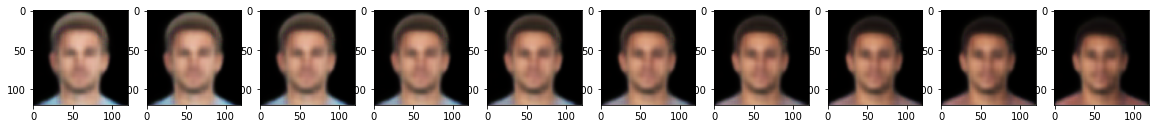

In [29]:
fig, ax = plt.subplots(1, 10, figsize=(20, 20))
for i in range(10):
    ax[i].imshow(y_mu[i].clamp(0, 1).cpu().detach().numpy().transpose(1, 2, 0))